# TransformerModelV0 with FewShotDataset

This notebook is an experimental approach on solving the ARC challenge. See https://arcprize.org/ for more details.

In [1]:
import os
import random

import torch

from pathlib import Path

from arc2024.data import FewShotDataset
from arc2024.utils import plot
from arc2024.utils.calc import accuracy_fn, norm_arc20204
from arc2024.models.transformer import TransformerModelV0

# Setup Device Agnostic Environment

In [2]:
import arc2024.utils.amdgpu as amd

if amd.is_amdgpu_on_linux():
    # Use ROCm on rx6600/6600xt by setting the environment variable HSA_OVERRIDE_GFX_VERSION to "10.3.0"
    # Source: https://github.com/ROCm/ROCm/issues/1698#issuecomment-1261646854
    amd.setup_amdgpu_environment(
        hsa_override_gfx_version="10.3.0"
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Prepare Datasets and DataLoaders

In [3]:
dataset_dir = Path('datasets')

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataset = FewShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='training',
    permutations_enabled=True
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataset = FewShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='evaluation'
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

## Train Model

In [4]:
model = TransformerModelV0(
    d_model=900,
    nhead=6,
    batch_first=True,
    device=device
)
model

TransformerModelV0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=900, out_features=900, bias=True)
          )
          (linear1): Linear(in_features=900, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=900, bias=True)
          (norm1): LayerNorm((900,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((900,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((900,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDeco

### Verify Input and Output Shapes with Random Tensor

In [5]:
x = torch.rand([1, 30, 30]).to(device)
model(x).shape

torch.Size([1, 1, 30, 30])

In [6]:
X, y, _ = train_dataset[0]
X = X.to(device) / 10
y = y.to(device) / 10

y_pred = model(X)
y_pred, y_pred.shape

(tensor([[[[ 1.2019e+00,  2.1161e-01,  1.4854e+00, -7.0095e-02, -8.9793e-03,
            -9.9936e-01,  2.4627e-01,  7.4914e-02, -1.1462e+00,  1.9437e+00,
             1.8814e+00, -2.2115e+00,  1.8520e+00,  6.0127e-02, -2.3021e-01,
            -3.7151e-01,  1.2995e+00, -1.1633e+00,  5.8855e-01,  9.3605e-01,
            -2.9831e-01, -1.3760e+00,  1.1182e+00, -1.3605e+00, -8.1838e-01,
             1.6203e+00,  1.0801e+00, -5.1714e-01,  7.5311e-01,  4.7102e-01],
           [ 2.3376e+00,  4.7956e-01, -4.5997e-01, -1.0288e+00, -1.6803e-01,
             8.8969e-01, -1.5457e+00, -4.0867e-01,  1.6201e+00, -5.8612e-01,
            -3.5708e-02, -5.7536e-01,  1.1787e+00, -1.6929e+00, -5.9471e-01,
            -2.8735e-01,  1.2577e+00, -2.7417e-01, -1.6669e+00, -2.1235e-01,
             7.6643e-01,  8.9910e-01,  1.3517e-01,  1.3935e+00, -6.8674e-01,
            -5.9062e-01,  1.2517e-01,  2.0255e+00,  1.1954e+00,  9.3893e-01],
           [-1.7312e+00,  1.2185e+00, -5.2190e-02, -7.8113e-01,  1.2428e+0

### Setup Loss, optimizer and evaluation metrics

In [7]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

### Run Training Loop

In [8]:
from timeit import default_timer as timer 

epochs = 50

time_start = timer()
for epoch in range(epochs):
    ### Training
    train_loss = 0
    train_accuracy = 0

    model.train() # Set model into training mode
    
    for b, (X_train, y_train, challenge_ids) in enumerate(train_dataloader):
        for challenge_id in challenge_ids:
            X_shots, y_shots = train_dataset.get_samples(challenge_id)
            X_shots, y_shots = X_shots.to(device) / 10, y_shots.to(device) / 10
            
            # Forward pass:
            shots_pred = model(X_shots, y_shots)
            
            # Calculate loss:
            loss = loss_fn(shots_pred, y_shots)
            
            # Reset optimizer gradients:
            optimizer.zero_grad()
            
            # Backward pass:
            loss.backward()
            
            # Adjust parameters:
            optimizer.step()
        
        # Send to device and normalize:
        X_train, y_train = X_train.to(device) / 10, y_train.to(device) / 10
        
        # Forward pass:
        train_pred = model(X_train, y_train)
        
        # Calculate loss:
        loss = loss_fn(train_pred, y_train)
        train_loss += loss
        train_accuracy += accuracy_fn(y_train, norm_arc20204(train_pred))
        
        # Reset optimizer gradients:
        optimizer.zero_grad()
        
        # Backward pass:
        loss.backward()
        
        # Adjust parameters:
        optimizer.step()

    train_loss /= len(train_dataloader.dataset)
    train_accuracy /= len(train_dataloader.dataset)
    
    ### Testing
    test_loss = 0
    test_accuracy = 0
    model.eval() # set model into evaluation mode

    with torch.inference_mode():
        for X_test, y_test, _ in test_dataloader:
            # Send to device and normalize:
            X_test, y_test = X_test.to(device) / 10, y_test.to(device) / 10

            # Forward pass:
            test_pred = model(X_test)

            # Calculate loss:
            loss = loss_fn(test_pred, y_test)
            test_loss += loss
            test_accuracy += accuracy_fn(y_test, norm_arc20204(test_pred))
    
        test_loss /= len(test_dataloader.dataset)
        test_accuracy /= len(test_dataloader.dataset)
    
    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%")
time_end = timer()

print(f"Total time taken: {time_end - time_start}")

Epoch 1/50 | Train loss: 0.02497 | Train accuracy: 0.05% | Test loss: 0.01947 | Test accuracy: 0.04%
Epoch 2/50 | Train loss: 0.01946 | Train accuracy: 0.05% | Test loss: 0.01618 | Test accuracy: 0.04%
Epoch 3/50 | Train loss: 0.01616 | Train accuracy: 0.05% | Test loss: 0.01323 | Test accuracy: 0.06%
Epoch 4/50 | Train loss: 0.01344 | Train accuracy: 0.05% | Test loss: 0.01134 | Test accuracy: 0.06%
Epoch 5/50 | Train loss: 0.01120 | Train accuracy: 0.05% | Test loss: 0.00999 | Test accuracy: 0.06%
Epoch 6/50 | Train loss: 0.00935 | Train accuracy: 0.05% | Test loss: 0.00854 | Test accuracy: 0.07%
Epoch 7/50 | Train loss: 0.00783 | Train accuracy: 0.05% | Test loss: 0.00762 | Test accuracy: 0.07%
Epoch 8/50 | Train loss: 0.00656 | Train accuracy: 0.05% | Test loss: 0.00672 | Test accuracy: 0.09%
Epoch 9/50 | Train loss: 0.00549 | Train accuracy: 0.05% | Test loss: 0.00607 | Test accuracy: 0.08%
Epoch 10/50 | Train loss: 0.00458 | Train accuracy: 0.05% | Test loss: 0.00557 | Test accur

# Evaluate Model

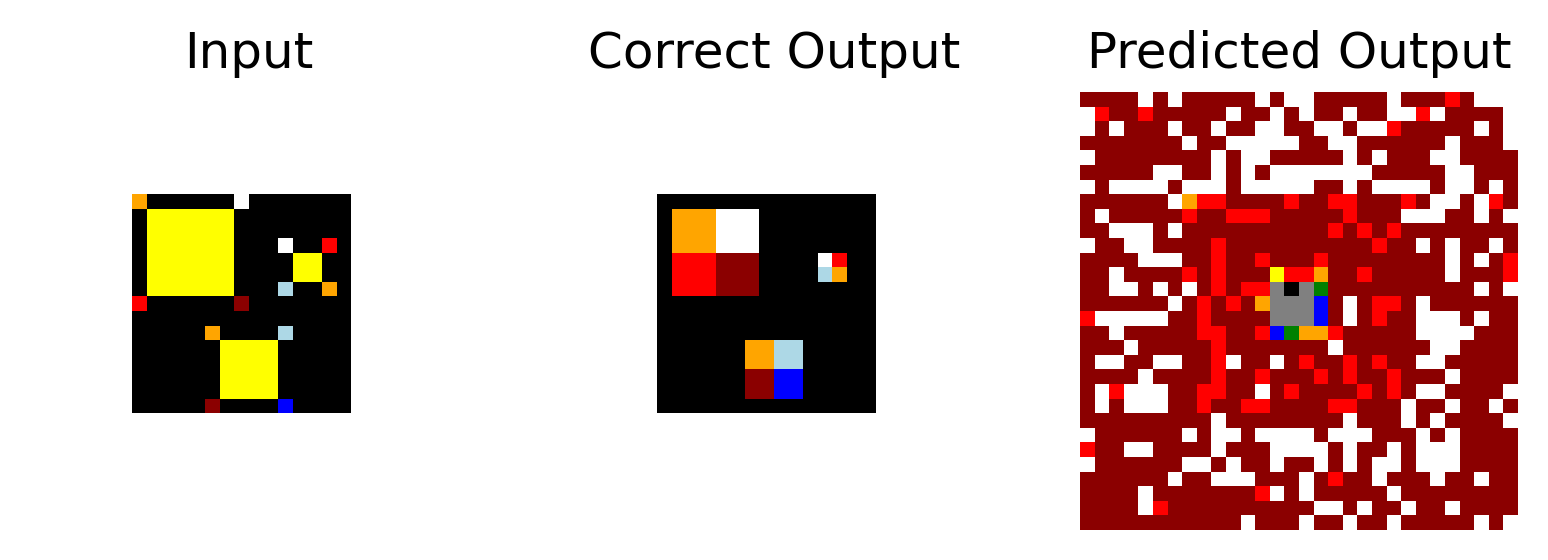

Accuracy: 1.67% (15/900)


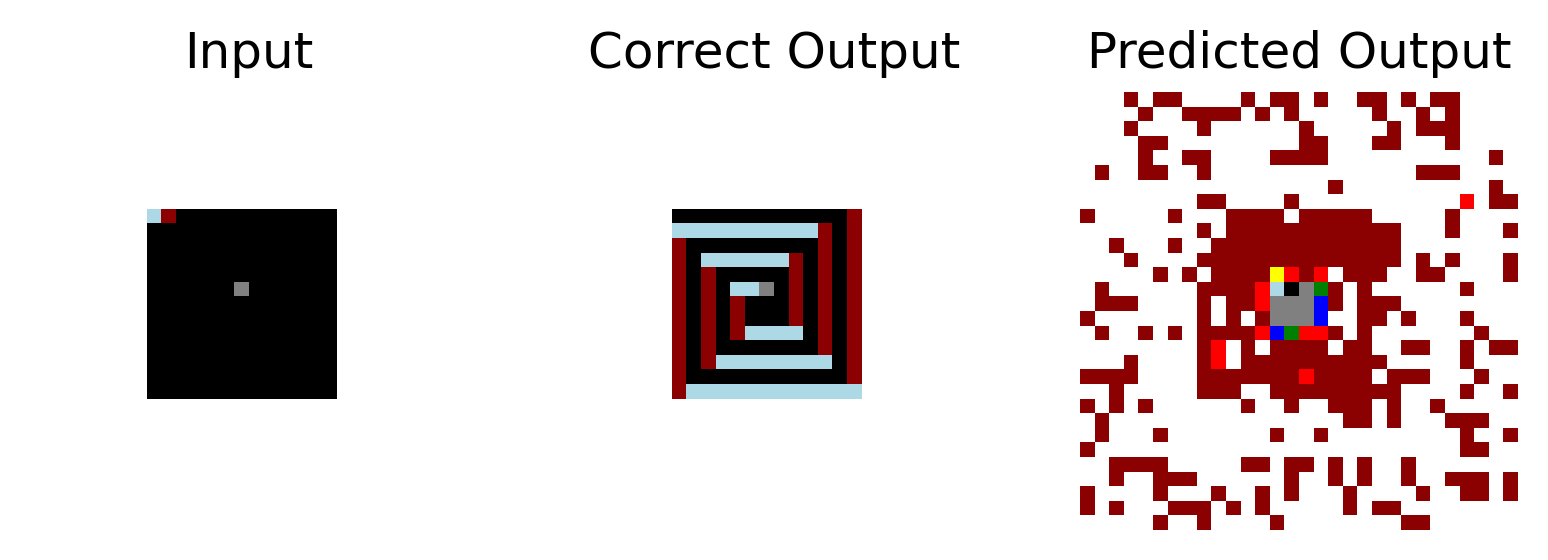

Accuracy: 7.78% (70/900)


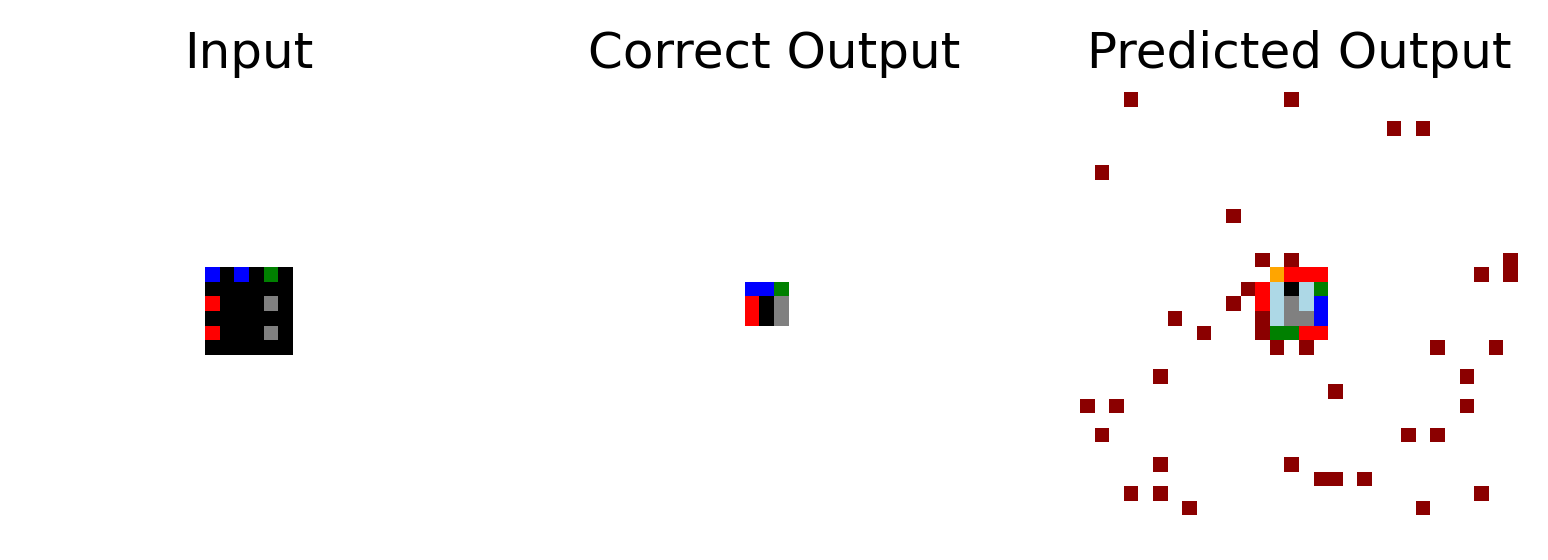

Accuracy: 12.89% (116/900)


In [11]:
evaluations = 3

evaluation_dataset = FewShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='evaluation'
)

model.eval() # set model into evaluation mode
with torch.inference_mode():
    
    for _ in range(evaluations):
        X, y, _ = random.choice(evaluation_dataset)
        X, y = X.to(device) / 10, y.to(device) / 10
        
        y_pred = model(X)[0]
        y_pred_norm = norm_arc20204(y_pred)
        
        plot.input_and_output(X * 10, y * 10, y_pred_norm * 10)
        accuracy_pred = accuracy_fn(y, y_pred_norm)
        print(f"Accuracy: {accuracy_pred:.2f}% ({int(accuracy_pred / 100 * 900)}/900)")
